# **기상 데이터 기반 LSTM 및 랜덤 포레스트를 활용한 미세먼지 농도 예측 모델 개발**

## **Attribute Information**


- **일자**           : 날짜  
- **기온**           : 기온 (°C)  
- **강수량(mm)**     : 강수량 (밀리미터)  
- **풍속(m/s)**      : 풍속 (초당 미터)  
- **풍향(16방위)**   : 풍향 (16방위)  
- **습도(%)**        : 습도 (퍼센트)  
- **증기압(hPa)**    : 증기압 (헥토파스칼)  
- **현지기압(hPa)**  : 현지기압 (헥토파스칼)  
- **일조(hr)**       : 일조 시간 (시간)  
- **일사(MJ/m2)**    : 일사량 (메가줄/제곱미터)  
- **지면온도(°C)**   : 지면 온도 (°C)  
- **오 존**          : 오존 농도  
- **이산화질소**     : 이산화질소 농도  
- **일산화탄소**     : 일산화탄소 농도  
- **아황산가스**     : 아황산가스 농도  
- **PM10**           : 미세먼지 PM10 농도  
- **PM2.5**          : 초미세먼지 PM2.5 농도



## **Data**
* train.csv
* test.csv




In [1]:
# 그래프에서 한글이 깨지지 않도록 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# Windows의 경우 설치된 폰트 중 하나 사용 (예: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# **1. 데이터 불러오기**

In [2]:
import pandas as pd

# train.csv 파일 불러오기
train_df = pd.read_csv('train.csv')

# 처음 5개의 행을 출력
train_df.head()

,일자,기온,강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),현지기압(hPa),일조(hr),일사(MJ/m2),지면온도(°C),오 존,이산화질소,일산화탄소,아황산가스,PM10,PM2.5
0,2020-01-01-00,-6.5,0.0,0.0,0.0,38,1.4,1022.6,NaN,NaN,-2.8,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01-01,-5.9,NaN,1.7,50.0,40,1.6,1021.8,NaN,NaN,-2.4,0.002,0.036,0.6,0.003,30,16
2,2020-01-01-02,-5.7,NaN,0.1,0.0,42,1.7,1021.6,NaN,NaN,-2.4,0.001,0.036,0.6,0.003,34,18
3,2020-01-01-03,-5.6,0.0,0.0,0.0,46,1.8,1021.5,NaN,NaN,-2.7,0.002,0.038,0.8,0.003,35,22
4,2020-01-01-04,-5.4,NaN,0.0,0.0,50,2.0,1021.6,NaN,NaN,-2.5,0.001,0.034,0.6,0.003,34,19


# **2. 데이터 전처리**

In [3]:
# 각 열에 존재하는 결측값의 개수를 계산
missing_values = train_df.isnull().sum()

# 각 열별 결측값 개수를 출력
print("각 열의 결측값 개수:")
print(missing_values)

# 전체 행 수를 기준으로 결측값이 차지하는 비율(%)을 계산
total_rows = len(train_df)
missing_percentage = (missing_values / total_rows) * 100

# 각 열별 결측값 비율을 소수점 둘째 자리까지 반올림하여 출력
print("\n각 열의 결측값 비율 (%):")
print(missing_percentage.round(2))

각 열의 결측값 개수:
일자               0
기온               1
강수량(mm)      31028
풍속(m/s)         39
풍향(16방위)        39
습도(%)            0
증기압(hPa)         2
현지기압(hPa)       13
일조(hr)       15899
일사(MJ/m2)    15899
지면온도(°C)        15
오 존            423
이산화질소         1603
일산화탄소          579
아황산가스          460
PM10           564
PM2.5          506
dtype: int64

각 열의 결측값 비율 (%):
일자            0.00
기온            0.00
강수량(mm)      88.49
풍속(m/s)       0.11
풍향(16방위)      0.11
습도(%)         0.00
증기압(hPa)      0.01
현지기압(hPa)     0.04
일조(hr)       45.34
일사(MJ/m2)    45.34
지면온도(°C)      0.04
오 존           1.21
이산화질소         4.57
일산화탄소         1.65
아황산가스         1.31
PM10          1.61
PM2.5         1.44
dtype: float64


In [4]:
# '강수량(mm)' 열 삭제
train_df = train_df.drop('강수량(mm)', axis=1)

# '일자' 열을 datetime 타입으로 변환
train_df['일자'] = pd.to_datetime(train_df['일자'])

# '일자'를 인덱스로 설정 (시계열 보간 정확도 향상)
train_df_index = train_df.set_index('일자')

# '일조(hr)', '일사(MJ/m2)' 열 결측값 시계열 보간
train_df_index['일조(hr)'] = train_df_index['일조(hr)'].interpolate(method='time')
train_df_index['일사(MJ/m2)'] = train_df_index['일사(MJ/m2)'].interpolate(method='time')

# 인덱스 초기화하여 '일자' 열 복원
train_df = train_df_index.reset_index()

# 처리 후 결측값 개수 확인
missing_after = train_df.isnull().sum()
print("결측값 처리 이후 각 열의 결측값 개수:")
print(missing_after)

# 변경 사항 확인용 출력
train_df.head()


결측값 처리 이후 각 열의 결측값 개수:
일자              0
기온              1
풍속(m/s)        39
풍향(16방위)       39
습도(%)           0
증기압(hPa)        2
현지기압(hPa)      13
일조(hr)          8
일사(MJ/m2)       8
지면온도(°C)       15
오 존           423
이산화질소        1603
일산화탄소         579
아황산가스         460
PM10          564
PM2.5         506
dtype: int64


,일자,기온,풍속(m/s),풍향(16방위),습도(%),증기압(hPa),현지기압(hPa),일조(hr),일사(MJ/m2),지면온도(°C),오 존,이산화질소,일산화탄소,아황산가스,PM10,PM2.5
0,2020-01-01 00:00:00,-6.5,0.0,0.0,38,1.4,1022.6,NaN,NaN,-2.8,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 01:00:00,-5.9,1.7,50.0,40,1.6,1021.8,NaN,NaN,-2.4,0.002,0.036,0.6,0.003,30,16
2,2020-01-01 02:00:00,-5.7,0.1,0.0,42,1.7,1021.6,NaN,NaN,-2.4,0.001,0.036,0.6,0.003,34,18
3,2020-01-01 03:00:00,-5.6,0.0,0.0,46,1.8,1021.5,NaN,NaN,-2.7,0.002,0.038,0.8,0.003,35,22
4,2020-01-01 04:00:00,-5.4,0.0,0.0,50,2.0,1021.6,NaN,NaN,-2.5,0.001,0.034,0.6,0.003,34,19


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   일자         35064 non-null  datetime64[ns]
 1   기온         35063 non-null  float64       
 2   풍속(m/s)    35025 non-null  float64       
 3   풍향(16방위)   35025 non-null  float64       
 4   습도(%)      35064 non-null  int64         
 5   증기압(hPa)   35062 non-null  float64       
 6   현지기압(hPa)  35051 non-null  float64       
 7   일조(hr)     35056 non-null  float64       
 8   일사(MJ/m2)  35056 non-null  float64       
 9   지면온도(°C)   35049 non-null  float64       
 10  오 존        34641 non-null  object        
 11  이산화질소      33461 non-null  object        
 12  일산화탄소      34485 non-null  object        
 13  아황산가스      34604 non-null  object        
 14  PM10       34500 non-null  object        
 15  PM2.5      34558 non-null  object        
dtypes: datetime64[ns](1), float64(8), int64(

In [6]:
# PM10, 오존, 이산화질소, 일산화탄소, 아황산가스 열을 수치형으로 변환
for col in ['PM10', '오 존', '이산화질소', '일산화탄소', '아황산가스']:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

# 결측치 채우기
for column in train_df.columns:
    if train_df[column].dtype != 'datetime64[ns]':
        if pd.api.types.is_numeric_dtype(train_df[column]):
            # 수치형 열은 평균값으로 대체
            train_df[column] = train_df[column].fillna(train_df[column].mean())
        else:
            # 비수치형 열은 최빈값으로 대체
            if not train_df[column].empty and len(train_df[column].mode()) > 0:
                train_df[column] = train_df[column].fillna(train_df[column].mode()[0])


# **3. 모델링 : LSTM**

Epoch 1/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0102 - val_loss: 0.0059
Epoch 2/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0073 - val_loss: 0.0055
Epoch 3/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 5/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 6/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 7/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 8/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 9/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 10/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 11/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 12/50
701/701 ━━━━━━━━━━

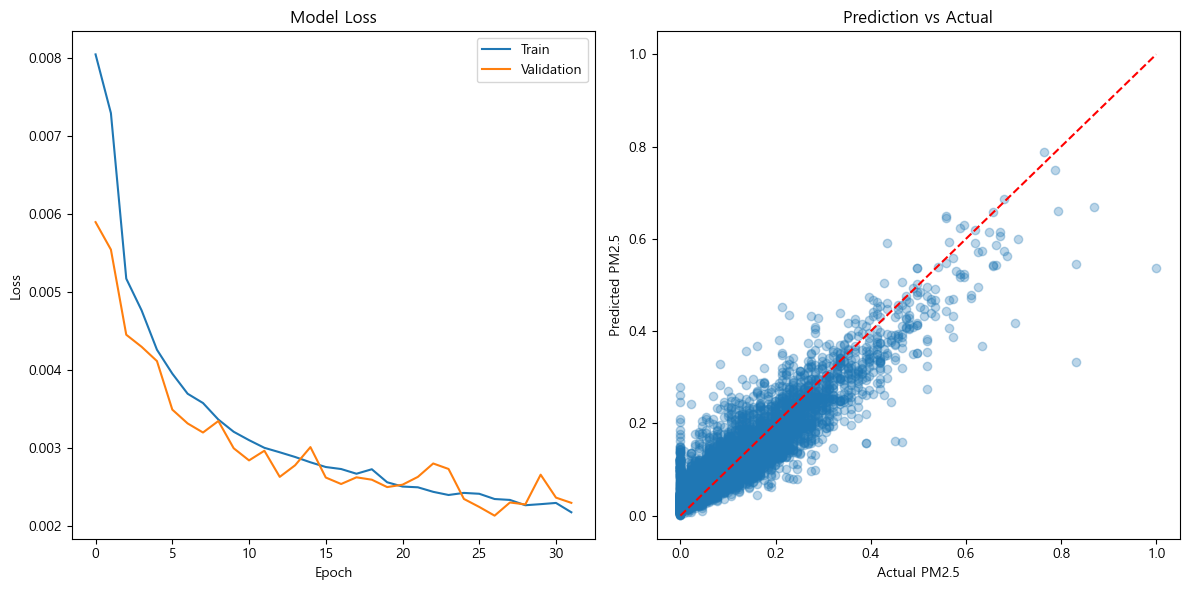

In [7]:
# LSTM 모델용 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# PM2.5를 수치형으로 변환
train_df['PM2.5'] = pd.to_numeric(train_df['PM2.5'], errors='coerce')

# 남아있는 결측치 평균값으로 대체
for column in train_df.columns:
    if train_df[column].dtype != 'datetime64[ns]':
        train_df[column] = train_df[column].fillna(train_df[column].mean())

# 예측에 사용할 특징(feature)과 목표(target) 변수 지정
features = ['기온', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '현지기압(hPa)', 
            '일조(hr)', '일사(MJ/m2)', '지면온도(°C)', 'PM10']
target = 'PM2.5'

# 시퀀스 데이터 생성 함수 정의
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

# 특징과 목표 데이터 추출 후 정규화
data = train_df[features + [target]].values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 시퀀스 길이 설정 (24시간)
seq_length = 24
X, y = create_sequences(data_scaled, seq_length)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM 모델 구성
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 조기 종료 콜백 설정 (val_loss 5회 연속 개선 없으면 종료)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# 테스트 데이터에 대한 손실값 평가
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

# 테스트 데이터 예측값 생성
y_pred = model.predict(X_test)

# 학습 과정 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# 예측값과 실제값 비교 그래프
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Prediction vs Actual')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')

plt.tight_layout()
plt.show()


# **4. 모델링 : Random Forest**

랜덤 포레스트 모델 학습 중...
3.10초 만에 학습 완료

모델 평가 결과:
Random Forest - MSE: 0.001838, R²: 0.835002
LSTM - MSE: 0.002050, R²: 0.808382


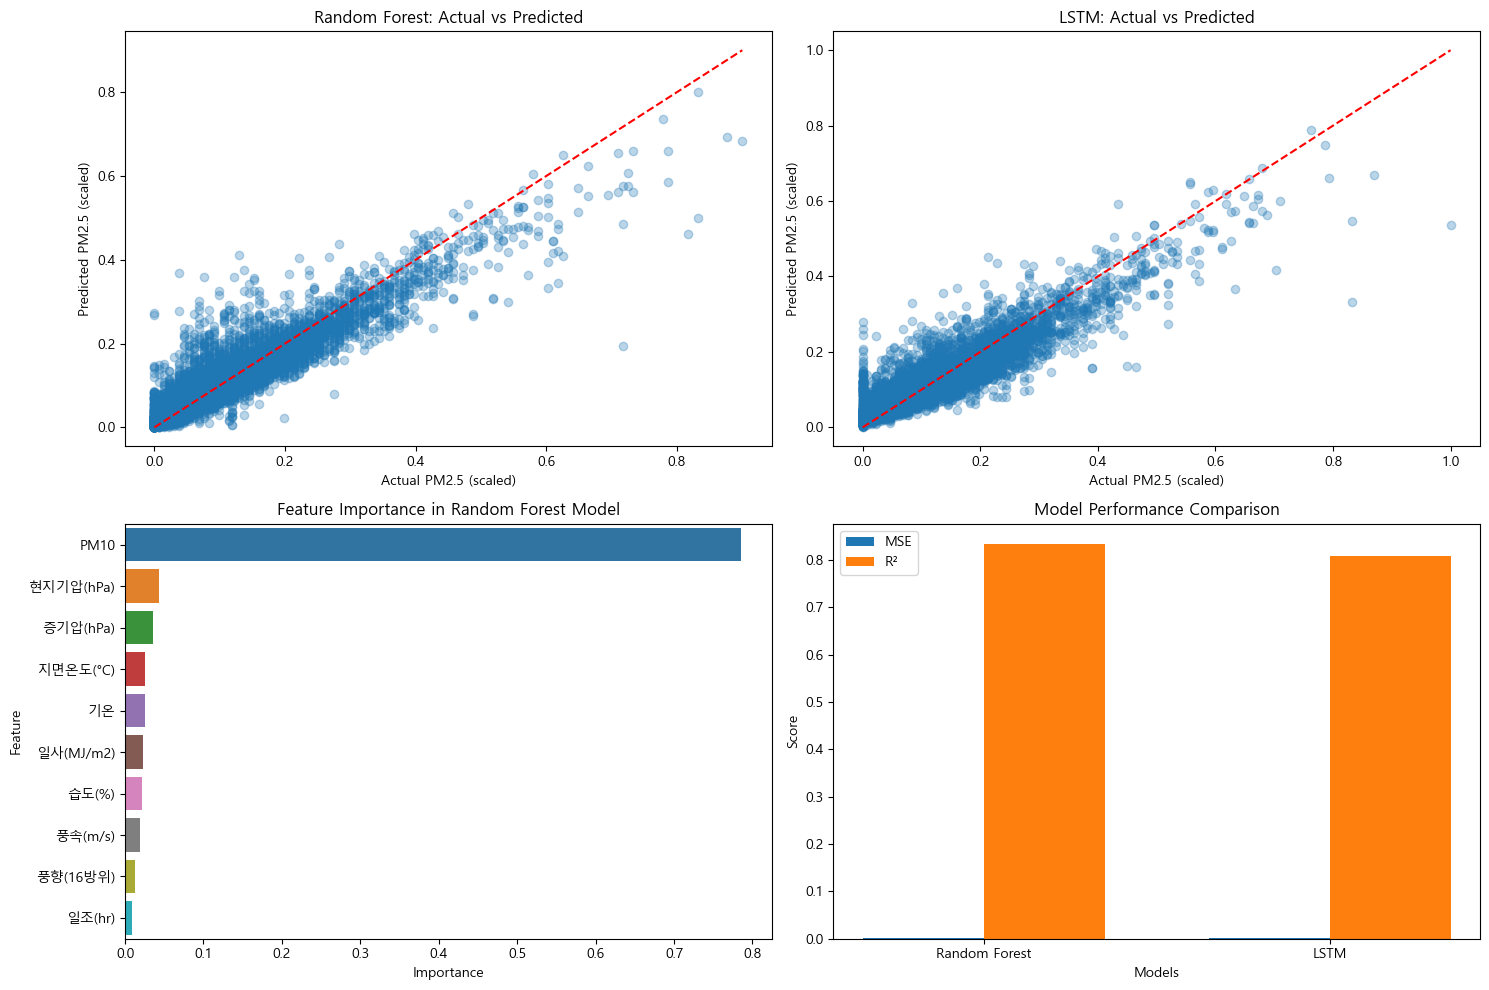

In [8]:
# 랜덤 포레스트에 필요한 라이브러리 불러오기
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
import seaborn as sns

# 랜덤 포레스트용 데이터 준비 (LSTM과 달리 시퀀스 생성 불필요)
# 스케일링 및 시퀀스 생성 전에 원본 피처 추출
X_data = train_df[features].values
y_data = train_df[target].values

# LSTM 모델과 동일한 train-test 분할 사용
# 단, 시퀀스가 필요 없으므로 데이터 형식만 맞춤
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_data_scaled = scaler_X.fit_transform(X_data)
y_data_scaled = scaler_y.fit_transform(y_data.reshape(-1, 1)).ravel()

# 일관성을 위해 같은 'random_state=42'로 train_test_split 실행
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_data_scaled, y_data_scaled, test_size=0.2, random_state=42
)

# 랜덤 포레스트 모델 학습 시작
print("랜덤 포레스트 모델 학습 중...")
start_time = time.time()
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=15,
    random_state=42, 
    n_jobs=-1  # 모든 CPU 코어 사용
)
rf_model.fit(X_train_rf, y_train_rf)
training_time = time.time() - start_time
print(f"{training_time:.2f}초 만에 학습 완료")

# 테스트 데이터에 대해 예측 수행
y_pred_rf = rf_model.predict(X_test_rf)

# 모델 평가 (MSE와 결정계수 R² 계산)
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)

# 비교를 위해 LSTM 모델 성능도 계산
mse_lstm = mean_squared_error(y_test, y_pred.ravel())
r2_lstm = r2_score(y_test, y_pred.ravel())

# 결과 출력
print("\n모델 평가 결과:")
print(f"Random Forest - MSE: {mse_rf:.6f}, R²: {r2_rf:.6f}")
print(f"LSTM - MSE: {mse_lstm:.6f}, R²: {r2_lstm:.6f}")

# 랜덤 포레스트 특성 중요도 계산 및 정렬
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# 결과 시각화
plt.figure(figsize=(15, 10))

# 1번 플롯: 랜덤 포레스트 실제값 vs 예측값 산점도
plt.subplot(2, 2, 1)
plt.scatter(y_test_rf, y_pred_rf, alpha=0.3)
plt.plot([min(y_test_rf), max(y_test_rf)], [min(y_test_rf), max(y_test_rf)], 'r--')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual PM2.5 (scaled)')
plt.ylabel('Predicted PM2.5 (scaled)')

# 2번 플롯: LSTM 실제값 vs 예측값 산점도 (기존 플롯과 유사)
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred.ravel(), alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('Actual PM2.5 (scaled)')
plt.ylabel('Predicted PM2.5 (scaled)')

# 3번 플롯: 랜덤 포레스트 모델 특성 중요도 시각화
plt.subplot(2, 2, 3)
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()

# 4번 플롯: 두 모델 성능 비교 (MSE와 R²)
plt.subplot(2, 2, 4)
model_names = ['Random Forest', 'LSTM']
mse_values = [mse_rf, mse_lstm]
r2_values = [r2_rf, r2_lstm]

bar_width = 0.35
x = np.arange(len(model_names))

plt.bar(x - bar_width/2, mse_values, bar_width, label='MSE')
plt.bar(x + bar_width/2, r2_values, bar_width, label='R²')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names)
plt.legend()

plt.tight_layout()
plt.show()


# **5. 테스트셋 평가 및 시각화**

테스트 데이터를 불러오고 전처리 중입니다...
Random Forest 예측을 수행 중입니다...
0.05초 만에 랜덤 포레스트 예측 완료
LSTM 예측 중입니다...
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
LSTM 예측이 2.64초 만에 완료되었습니다

테스트 데이터 성능 평가 결과:
Random Forest - MSE: 24.3711, R²: 0.7814
LSTM - MSE: 34.3884, R²: 0.6916


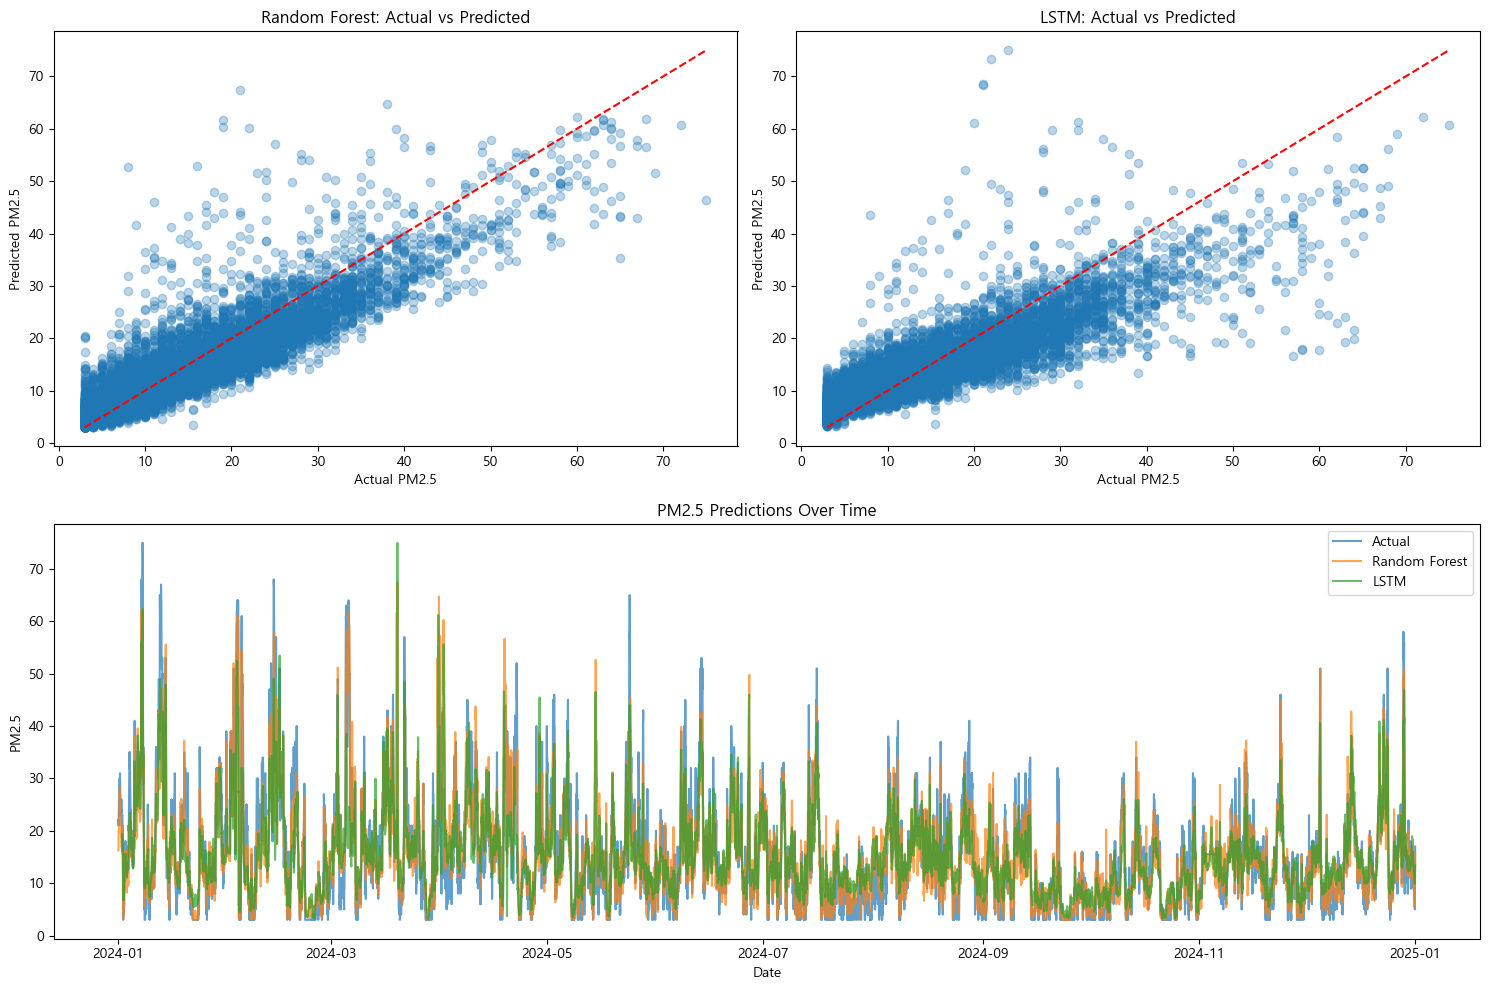

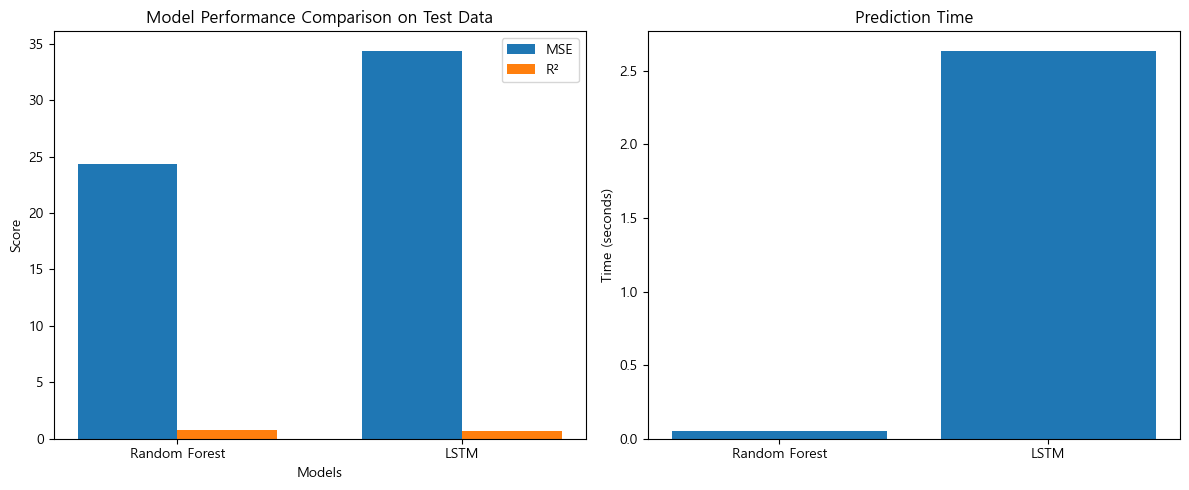

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 테스트 데이터 불러오고 전처리
print("테스트 데이터를 불러오고 전처리 중입니다...")
test_df = pd.read_csv('test.csv')

# '일자'를 datetime 형식으로 변환
test_df['일자'] = pd.to_datetime(test_df['일자'])

# PM2.5 및 다른 컬럼을 숫자형으로 변환
test_df['PM2.5'] = pd.to_numeric(test_df['PM2.5'], errors='coerce')
for col in ['PM10', '오 존', '이산화질소', '일산화탄소', '아황산가스']:
    if col in test_df.columns:
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

# 결측값 채우기
for column in test_df.columns:
    if test_df[column].dtype != 'datetime64[ns]':
        if pd.api.types.is_numeric_dtype(test_df[column]):
            # 숫자형 컬럼은 평균값으로 채움
            test_df[column] = test_df[column].fillna(test_df[column].mean())
        else:
            # 숫자형이 아닌 컬럼은 최빈값으로 채움
            if not test_df[column].empty and len(test_df[column].mode()) > 0:
                test_df[column] = test_df[column].fillna(test_df[column].mode()[0])

# 테스트 데이터에 필요한 특성들이 모두 있는지 확인
required_features = features + [target]
missing_features = [col for col in required_features if col not in test_df.columns]

if missing_features:
    print(f"경고: 테스트 데이터에 누락된 특성(컬럼)이 있습니다: {missing_features}")
    print("예측을 진행할 수 없습니다.")
else:
    # 테스트 데이터에서 특성과 타깃 추출
    X_test_data = test_df[features].values
    y_test_data = test_df[target].values

# 훈련 때 사용한 스케일러로 데이터 스케일링
X_test_data_scaled = scaler_X.transform(X_test_data)
y_test_data_scaled = scaler_y.transform(y_test_data.reshape(-1, 1)).flatten()

# 랜덤포레스트 예측
print("Random Forest 예측을 수행 중입니다...")
start_time = time.time()
rf_predictions_scaled = rf_model.predict(X_test_data_scaled)
rf_time = time.time() - start_time
print(f"{rf_time:.2f}초 만에 랜덤 포레스트 예측 완료")

# 실제 값으로 역변환
rf_predictions = scaler_y.inverse_transform(rf_predictions_scaled.reshape(-1, 1)).flatten()

# LSTM 예측
print("LSTM 예측 중입니다...")
start_time = time.time()

# LSTM 입력용 시퀀스 생성 함수
def create_lstm_test_sequences(data, seq_length):
    X = []
    valid_indices = []
    
    for i in range(len(data) - seq_length + 1):
        X.append(data[i:i+seq_length])
        valid_indices.append(i + seq_length - 1)
        
    return np.array(X), np.array(valid_indices)

# LSTM용 시퀀스 생성
X_test_seq, valid_indices = create_lstm_test_sequences(X_test_data_scaled, seq_length)

# 예측 수행
lstm_predictions_scaled = model.predict(X_test_seq)
lstm_time = time.time() - start_time
print(f"LSTM 예측이 {lstm_time:.2f}초 만에 완료되었습니다")

# 실제 값으로 역변환
lstm_predictions = scaler_y.inverse_transform(lstm_predictions_scaled).flatten()

# 예측이 없는 위치에는 NaN으로 채운 배열 생성
full_lstm_predictions = np.full(len(test_df), np.nan)
full_lstm_predictions[valid_indices] = lstm_predictions

# 성능 평가
# 랜덤포레스트는 모든 데이터에 대해 평가
rf_mse = mean_squared_error(y_test_data, rf_predictions)
rf_r2 = r2_score(y_test_data, rf_predictions)

# LSTM은 유효한 인덱스에 대해서만 평가
lstm_mse = mean_squared_error(y_test_data[valid_indices], lstm_predictions)
lstm_r2 = r2_score(y_test_data[valid_indices], lstm_predictions)

# 성능 지표 출력
print("\n테스트 데이터 성능 평가 결과:")
print(f"Random Forest - MSE: {rf_mse:.4f}, R²: {rf_r2:.4f}")
print(f"LSTM - MSE: {lstm_mse:.4f}, R²: {lstm_r2:.4f}")

# 결과 시각화
plt.figure(figsize=(15, 10))

# 그래프 1: 랜덤포레스트 실제값 vs 예측값
plt.subplot(2, 2, 1)
plt.scatter(y_test_data, rf_predictions, alpha=0.3)
plt.plot([min(y_test_data), max(y_test_data)], [min(y_test_data), max(y_test_data)], 'r--')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')

# 그래프 2: LSTM 실제값 vs 예측값 (유효 인덱스만)
plt.subplot(2, 2, 2)
plt.scatter(y_test_data[valid_indices], lstm_predictions, alpha=0.3)
plt.plot([min(y_test_data), max(y_test_data)], [min(y_test_data), max(y_test_data)], 'r--')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')

# 그래프 3: 시간에 따른 예측값 시계열
plt.subplot(2, 1, 2)
plt.plot(test_df['일자'], y_test_data, label='Actual', alpha=0.7)
plt.plot(test_df['일자'], rf_predictions, label='Random Forest', alpha=0.7)
plt.plot(test_df['일자'], full_lstm_predictions, label='LSTM', alpha=0.7)
plt.title('PM2.5 Predictions Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

plt.tight_layout()
plt.show()

# 성능 비교 막대 그래프
plt.figure(figsize=(12, 5))
model_names = ['Random Forest', 'LSTM']
mse_values = [rf_mse, lstm_mse]
r2_values = [rf_r2, lstm_r2]

# 그래프 1: 성능 지표
plt.subplot(1, 2, 1)
bar_width = 0.35
x = np.arange(len(model_names))

plt.bar(x - bar_width/2, mse_values, bar_width, label='MSE')
plt.bar(x + bar_width/2, r2_values, bar_width, label='R²')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison on Test Data')
plt.xticks(x, model_names)
plt.legend()

# 그래프 2: 예측 소요 시간
plt.subplot(1, 2, 2)
time_values = [rf_time, lstm_time]
plt.bar(model_names, time_values)
plt.title('Prediction Time')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()


# **6. 앙상블(LSTM + Random Forest) 예측 및 성능 평가**

앙상블 모델 예측 생성 중...
최적 가중치 발견: RF=0.83, LSTM=0.17
앙상블 예측이 0.05초 만에 완료되었습니다

앙상블 모델 성능:
앙상블 - MSE: 23.9408, 결정계수(R²): 0.7853
Random Forest - MSE: 24.3711, 결정계수(R²): 0.7814
LSTM - MSE: 34.3884, 결정계수(R²): 0.6916


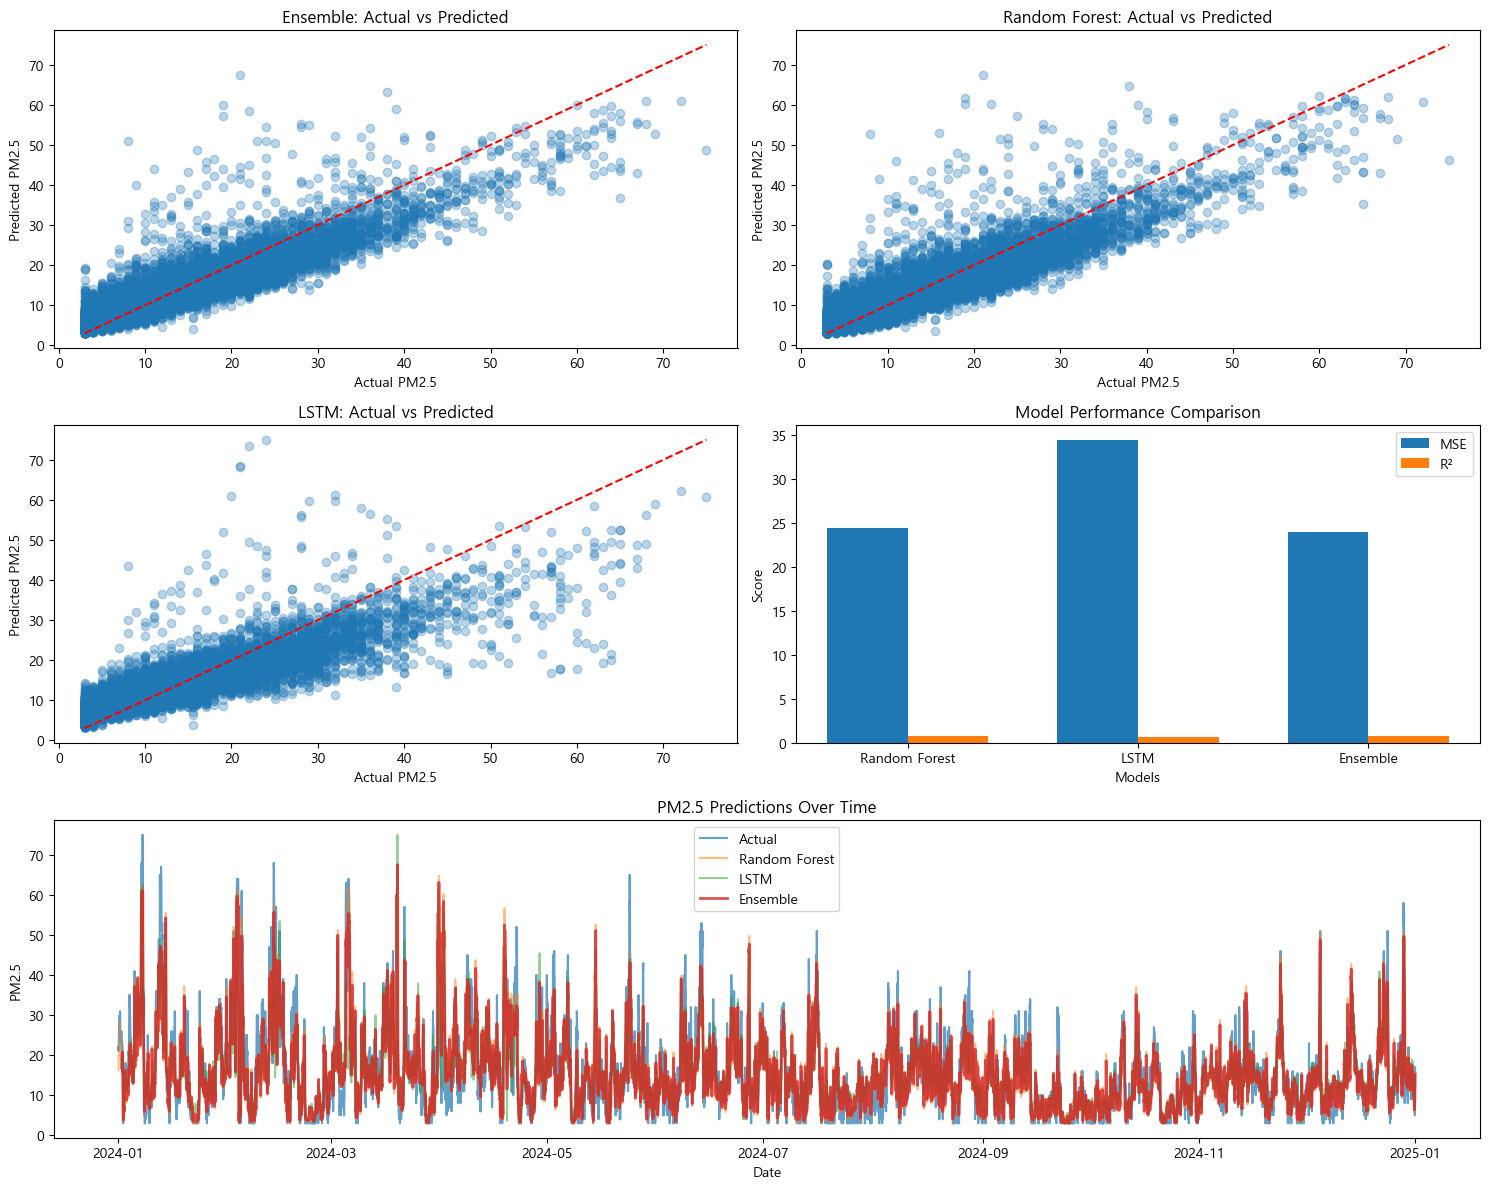


최근 10개 예측 결과:
                      일자  Actual_PM2.5  RF_Prediction  LSTM_Prediction  \
8774 2024-12-31 14:00:00          10.0       9.130704        12.275837   
8775 2024-12-31 15:00:00           7.0       8.649442        11.823977   
8776 2024-12-31 16:00:00           8.0       8.672035        11.431008   
8777 2024-12-31 17:00:00          10.0       7.976678        11.454025   
8778 2024-12-31 18:00:00           7.0       5.504963        10.585111   
8779 2024-12-31 19:00:00           7.0       8.156286        10.953122   
8780 2024-12-31 20:00:00           9.0       7.580865         9.897909   
8781 2024-12-31 21:00:00           5.0       9.031565        11.086212   
8782 2024-12-31 22:00:00          11.0      12.784929        12.154041   
8783 2024-12-31 23:00:00          17.0      15.631066        13.397535   

      Ensemble_Prediction  
8774             9.665377  
8775             9.189113  
8776             9.141061  
8777             8.567827  
8778             6.368588  
87

In [10]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 앙상블을 위한 최적 가중치 찾기 함수
def find_optimal_weights(y_true, y_pred1, y_pred2):
    """
    두 모델의 예측값을 결합하는 최적 가중치를 찾습니다.
    y_pred1에 w를 곱하고 y_pred2에 (1-w)를 곱합니다.
    """
    best_mse = float('inf')
    best_weight = 0.5
    
    # 0부터 1까지 0.01 간격으로 가중치 테스트
    for w in np.arange(0, 1.01, 0.01):
        ensemble_pred = w * y_pred1 + (1 - w) * y_pred2
        mse = mean_squared_error(y_true, ensemble_pred)
        if mse < best_mse:
            best_mse = mse
            best_weight = w
    
    return best_weight, best_mse

print("앙상블 모델 예측 생성 중...")
start_time = time.time()

# LSTM은 valid_indices에 대해서만 예측값이 있으므로, 해당 인덱스에 대해서만 랜덤포레스트 예측값 준비
rf_valid_predictions = rf_predictions[valid_indices]

# 최적 가중치 찾기
optimal_weight, _ = find_optimal_weights(
    y_test_data[valid_indices], 
    rf_valid_predictions, 
    lstm_predictions
)

print(f"최적 가중치 발견: RF={optimal_weight:.2f}, LSTM={1-optimal_weight:.2f}")

# 최적 가중치로 앙상블 예측값 계산
ensemble_predictions = optimal_weight * rf_valid_predictions + (1 - optimal_weight) * lstm_predictions
ensemble_time = time.time() - start_time

# 전체 테스트셋 길이만큼 NaN으로 채운 배열 생성 후, valid_indices 위치에 앙상블 예측값 할당
full_ensemble_predictions = np.full(len(test_df), np.nan)
full_ensemble_predictions[valid_indices] = ensemble_predictions

# 앙상블 모델 성능 평가
ensemble_mse = mean_squared_error(y_test_data[valid_indices], ensemble_predictions)
ensemble_r2 = r2_score(y_test_data[valid_indices], ensemble_predictions)

print(f"앙상블 예측이 {ensemble_time:.2f}초 만에 완료되었습니다")
print("\n앙상블 모델 성능:")
print(f"앙상블 - MSE: {ensemble_mse:.4f}, 결정계수(R²): {ensemble_r2:.4f}")
print(f"Random Forest - MSE: {rf_mse:.4f}, 결정계수(R²): {rf_r2:.4f}")
print(f"LSTM - MSE: {lstm_mse:.4f}, 결정계수(R²): {lstm_r2:.4f}")

plt.figure(figsize=(15, 12))

# 앙상블 실제 vs 예측값 산점도
plt.subplot(3, 2, 1)
plt.scatter(y_test_data[valid_indices], ensemble_predictions, alpha=0.3)
plt.plot([min(y_test_data), max(y_test_data)], [min(y_test_data), max(y_test_data)], 'r--')
plt.title('Ensemble: Actual vs Predicted')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')

# 랜덤포레스트 실제 vs 예측값 산점도
plt.subplot(3, 2, 2)
plt.scatter(y_test_data[valid_indices], rf_valid_predictions, alpha=0.3)
plt.plot([min(y_test_data), max(y_test_data)], [min(y_test_data), max(y_test_data)], 'r--')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')

# LSTM 실제 vs 예측값 산점도
plt.subplot(3, 2, 3)
plt.scatter(y_test_data[valid_indices], lstm_predictions, alpha=0.3)
plt.plot([min(y_test_data), max(y_test_data)], [min(y_test_data), max(y_test_data)], 'r--')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')

# 모델별 성능 비교 막대 그래프
plt.subplot(3, 2, 4)
model_names = ['Random Forest', 'LSTM', 'Ensemble']
mse_values = [rf_mse, lstm_mse, ensemble_mse]
r2_values = [rf_r2, lstm_r2, ensemble_r2]

bar_width = 0.35
x = np.arange(len(model_names))

plt.bar(x - bar_width/2, mse_values, bar_width, label='MSE')
plt.bar(x + bar_width/2, r2_values, bar_width, label='R²')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names)
plt.legend()

# 시간에 따른 PM2.5 예측 시계열 그래프
plt.subplot(3, 1, 3)
plt.plot(test_df['일자'], y_test_data, label='Actual', alpha=0.7)
plt.plot(test_df['일자'], rf_predictions, label='Random Forest', alpha=0.5)
plt.plot(test_df['일자'], full_lstm_predictions, label='LSTM', alpha=0.5)
plt.plot(test_df['일자'], full_ensemble_predictions, label='Ensemble', alpha=0.8, linewidth=2)
plt.title('PM2.5 Predictions Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

plt.tight_layout()
plt.show()

# 예측 결과 저장
results_df = pd.DataFrame({
    '일자': test_df['일자'],
    'Actual_PM2.5': y_test_data,
    'RF_Prediction': rf_predictions,
    'LSTM_Prediction': full_lstm_predictions,
    'Ensemble_Prediction': full_ensemble_predictions
})

# 결측값이 아닌 앙상블 예측값만 필터링하여 최근 10개 출력
valid_results = results_df.dropna(subset=['Ensemble_Prediction']).tail(10)
print("\n최근 10개 예측 결과:")
print(valid_results[['일자', 'Actual_PM2.5', 'RF_Prediction', 'LSTM_Prediction', 'Ensemble_Prediction']])